# Homework 11

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Saturday, December 1st, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

**Joe Davison<br>
Anna Davydova<br>
Michael S. Emanuel<br>
Dylan Randle**

<div class="answer-separator">
------------------------
</div>

In [36]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns

%matplotlib inline

In [37]:
# Additional imports
import pymc3 as pm
import pickle
from IPython.display import display, HTML
from typing import Dict

In [38]:
# Serialization
def load_vartbl(fname: str) -> Dict:
    """Load a dictionary of variables from a pickled file"""
    try:
        with open(fname, 'rb') as fh:
            vartbl = pickle.load(fh)
    except:
        vartbl = dict()
    return vartbl


def save_vartbl(vartbl: Dict, fname: str) -> None:
    """Save a dictionary of variables to the given file with pickle"""
    with open(fname, 'wb') as fh:
        pickle.dump(vartbl, fh)

# *************************************************************************************************
# Load persisted table of variables
fname: str = 'census_income.pickle'
vartbl: Dict = load_vartbl(fname)

## Question 1: Crazy Rich Bayesians Don't Need No Educations?

**coding required**

In this problem, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in ["Statistical Rethinking"](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjopa0chtr7ns%2FStatistical_Rethinking_excerpt.pdf), the excerpt of which is included with this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given data from the [1994 U.S. Census](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9zvsjoscq%2Fcensus_data.csv). The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

1.1. Read the dataset into a dataframe and aggregate the dataset by organizing the  dataframe into seven different categories. 

The categories we wish to consider are: 
* 4 year college degree
* Some-college or two year academic college degree
* High school
* Professional, vocational school
* Masters 
* Doctorate
* Some or no high school

Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) the crazy rich income of $50k (see the dataset in Example 10.1.3). 

1.2. Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

1.3. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. 

1.4. Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. One of the models should take into account education only the other should take into account gender and education on income.

1.5. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data.

1.6. Using your analysis from 1.3, discuss the effect gender has on income.

1.7. Using your analysis from 1.5, discuss the effect of gender on income taking into account an individual's education.

(**Hint: If you haven't seen WAIC, it's because we'll be covering it on Monday November 26, 2018.  In the meantime checkout info about WAIC in this resource on [PyMC3 model selection](https://docs.pymc.io/notebooks/model_comparison.html).**)

**1.1** 1.1. Read the dataset into a dataframe and aggregate the dataset by organizing the dataframe into seven different categories.

In [39]:
def load_data():
    """Load data and aggregate it by education and sex"""

    # Read in the full dataframe
    df_full = pd.read_csv('census_data.csv', index_col=0)
    
    # Map from census education categories to new categories
    education_map = {
        'Preschool' : 'Not-HS-Grad',
        '1st-4th' : 'Not-HS-Grad',
        '5th-6th' : 'Not-HS-Grad',
        '7th-8th' : 'Not-HS-Grad',
        '9th' : 'Not-HS-Grad',
        '10th' : 'Not-HS-Grad',
        '11th' : 'Not-HS-Grad',
        '12th' : 'Not-HS-Grad',
        'HS-grad': 'HS-Grad',
        'Some-college': 'College-Lite',
        'Assoc-acdm': 'College-Lite',
        'Assoc-voc': 'Prof-Voc',
        'Prof-school': 'Prof-Voc',
        'Bachelors': 'Bachelors',
        'Masters': 'Masters',
        'Doctorate': 'Doctorate'
        }
    
    educationID_map = {
        'Not-HS-Grad': 0,
        'HS-Grad': 1,
        'College-Lite': 2,
        'Prof-Voc': 3,
        'Bachelors': 4,
        'Masters': 5,
        'Doctorate': 6
    }
    
    sexID_map = {
            'Male' : 0,
            'Female' : 1
    }
    
    # Map from census income to a float (1.0 for high earning)
    earning_map =  {
        '<=50K': 0.0,
        '>50K': 1.0}
    
    # New series for education and earnings
    education = pd.Series(df_full.edu.map(education_map), name='education')
    education_id = pd.Series(education.map(educationID_map), name='education_id', dtype='category')
    # We also want the sex
    sex = df_full.sex
    sex_id = pd.Series(sex.map(sexID_map), name='sex_id', dtype='category')
    # The earnings (trying to predict this)
    earn_hi = pd.Series(df_full.earning.map(earning_map), name='earn_hi', dtype=np.int64)
    
    # Create a new dataframe
    df = pd.concat([education_id, sex_id, education, sex, earn_hi], axis=1, 
                   names=['education_id', 'sex_id', 'education', 'sex', 'earn_hi'])    
    # Aggregate counts of high and low earners by education for males and females as per hint
    # For each category, we suggest that you only keep track of a count of the number of males and females 
    # who make above (and resp. below) the crazy rich income of $50k (see the dataset in Example 10.1.3).
    # https://stackoverflow.com/questions/19384532/how-to-count-number-of-rows-per-group-and-other-statistics-in-pandas-group-by
    gb = df.groupby(by=[education_id, sex_id])
    counts = gb.size().to_frame(name='count')
    df_agg = counts.join(gb.agg({'earn_hi': 'sum'})).reset_index()
    # Add indicators is_male, is_female
    df_agg['is_male'] = np.zeros_like(df_agg.education_id, dtype=float)
    df_agg['is_female'] = np.zeros_like(df_agg.education_id, dtype=float)
    # Set is_male to 1.0 on the male entries
    mask_male = (df_agg.sex_id == 0)
    df_agg.loc[mask_male, 'is_male'] = 1.0
    # Set is_female to 1.0 on the female entries
    mask_female = (df_agg.sex_id == 1)
    df_agg.loc[mask_female, 'is_female'] = 1.0
    # Return the dataframe    
    return df_agg, educationID_map, sexID_map

In [40]:
df, educationID_map, sexID_map = load_data()
display(df)

,education_id,sex_id,count,earn_hi,is_male,is_female
0,0,0,2932,221,1.0,0.0
1,0,1,1321,23,0.0,1.0
2,1,0,7111,1449,1.0,0.0
3,1,1,3390,226,0.0,1.0
4,2,0,5131,1399,1.0,0.0
5,2,1,3227,253,0.0,1.0
6,3,0,1366,675,1.0,0.0
7,3,1,592,109,0.0,1.0
8,4,0,3736,1882,1.0,0.0
9,4,1,1619,339,0.0,1.0


**1.2** Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above $50k and 0 being below), one of these models should include the effect of gender while the other should not.

In [41]:
# Shared configuration for all models in 1.2 & 1.4
# Number of educational categories
num_sex: int = len(sexID_map)
num_edu: int = len(educationID_map)

# Size for models
num_obs: int = len(df)

# Mean and Standard Deviation of distribution for alpha (constant term)
alpha_mu: float = 0.0
alpha_sd: float = 10.0

# Mean and Standard Deviation of distribution for beta (impact of sex on likelihood of high earnings)
beta_sex_mu: float = 0.0
beta_sex_sd: float = 10.0

# Mean and Standard Deviation of distribution for alpha by eductation
beta_edu_mu: float = 0.0
beta_edu_sd: float = 10.0

# The number of samples to draw
num_samples: int = 100000

In [45]:
# Create a baseline model with just a constant; name it model_base
with pm.Model() as model_base:
    # The alpha shared by all categories
    alpha = pm.Normal(name='alpha', mu=alpha_mu, sd=alpha_sd)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', alpha)
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_base
try:
    model_base_trace = vartbl['model_base_trace']
    print(f'Loaded model_base_trace from variable table in {fname}.')
except:    
    with model_base:
        # Need to manually specify cores=1 or this blows up on windows.
        # this is a a known bug on pymc3
        # https://github.com/pymc-devs/pymc3/issues/3140
        model_base_trace = pm.sample(10000, chains=2, cores=1)
    vartbl['model_base_trace'] = model_base_trace
    save_vartbl(vartbl, fname)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [logit_p]
100%|██████████████████████████████████████████████████████████████████████████| 10500/10500 [00:03<00:00, 3039.20it/s]
C:\Python\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8843285243766866, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8841977070159209, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E67563B70>,
      dtype=object)

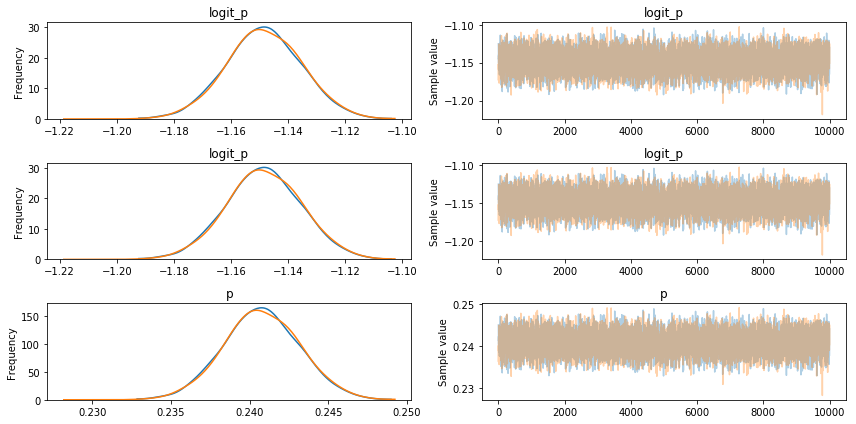

In [49]:
# Review outputs of model_base
display(pm.traceplot(model_base_trace))

In [46]:
# Create a model using only sex; name it model_sex
with pm.Model() as model_sex:
    # The beta for the two sex categories
    beta_sex = pm.Normal(name='beta_sex', mu=beta_sex_mu, sd=beta_sex_sd, shape=num_sex)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', beta_sex[df.sex_id])
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_sex
try:
    model_sex_trace = vartbl['model_sex_trace']
    print(f'Loaded model_sex_trace from variable table in {fname}.')
except:    
    with model_sex:
        # Need to manually specify cores=1 or this blows up on windows.
        # this is a a known bug on pymc3
        # https://github.com/pymc-devs/pymc3/issues/3140
        model_sex_trace = pm.sample(10000, chains=2, cores=1)
    vartbl['model_sex_trace'] = model_sex_trace
    save_vartbl(vartbl, fname)

C:\Python\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Loaded model_sex_trace from variable table in census_income.pickle.


C:\Python\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E662B91D0>,
      dtype=object)

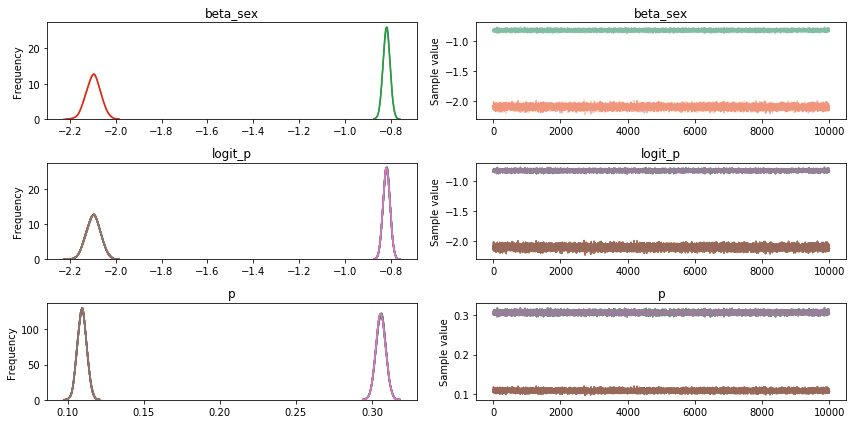

In [52]:
# Review outputs of model_sex
display(pm.traceplot(model_sex_trace))

**1.3**. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data.

In [53]:
# Create a model using only education; name it model_edu
with pm.Model() as model_edu:
    # The beta for each of the seven educational categories
    beta_edu = pm.Normal(name='beta_edu', mu=beta_edu_mu, sd=beta_edu_sd, shape=num_edu)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', beta_edu[df.education_id])
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_edu
try:
    model_edu_trace = vartbl['model_edu_trace']
    print(f'Loaded model_edu_trace from {fname}.')
except:    
    with model_edu:
        model_edu_trace = pm.sample(10000, chains=2, cores=1)
    vartbl['model_edu_trace'] = model_edu_trace
    save_vartbl(vartbl, fname)

C:\Python\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_edu]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:16<00:00, 641.54it/s]
C:\Python\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft

C:\Python\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E68C167B8>,
      dtype=object)

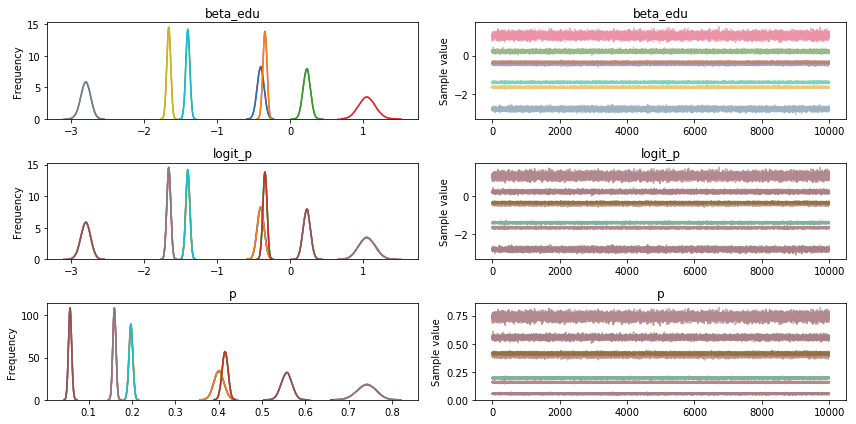

In [54]:
# Review outputs of model_edu
display(pm.traceplot(model_edu_trace))

In [ ]:
# Create a model using both education and sex; name it model_edu_sex
with pm.Model() as model_edu_sex:
    # The beta for each of the seven educational categories
    beta_edu = pm.Normal(name='beta_edu', mu=beta_edu_mu, sd=beta_edu_sd, shape=num_edu)
    # The beta for the two sex categories
    beta_sex = pm.Normal(name='beta_sex', mu=beta_sex_mu, sd=beta_sex_sd, shape=num_sex)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', beta_edu[df.education_id] + beta_sex[df.sex_id])
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_edu_sex
try:
    model_edu_sex_trace = vartbl['model_edu_sex_trace']
    print(f'Loaded model_edu_sex_trace from {fname}.')
except:    
    with model_edu_sex:
        model_edu_sex_trace = pm.sample(10000, chains=2, cores=1)
    vartbl['model_edu_sex_trace'] = model_edu_sex_trace
    save_vartbl(vartbl, fname)

C:\Python\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Python\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (2 chains in 1 job)
NUTS: [beta_sex, beta_edu]
 14%|██████████▉                                                                  | 1

In [ ]:
# Review outputs of model_edu_sex
display(pm.traceplot(model_edu_sex_trace))

**1.4**. Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. One of the models should take into account education only the other should take into account gender and education on income.

**Gratuitous Titular Reference**:  

If you haven't watched [Crazy Rich Asians](http://www.crazyrichasiansmovie.com/) then it might be time.

If you haven't listened to [Pink Floyd's](https://en.wikipedia.org/wiki/Pink_Floyd) [The Wall](https://en.wikipedia.org/wiki/The_Wall) then it might be time.

Also who are you? :-)

Anyway [You don't need no thought control](https://www.youtube.com/watch?v=YR5ApYxkU-U), [You probably want us teaching staff to leave you kids alone](https://www.youtube.com/watch?v=YR5ApYxkU-U), and [Education is overrated, right?  You don't need it!](https://www.youtube.com/watch?v=YR5ApYxkU-U)

<div class="answer-separator">
------------------------
</div>

## Question 2:  My Sister-In-Law's Baby Cousin Tracy ...

**coding required**

Wikipedia describes the National Annenberg Election Survey as follows -- "National Annenberg Election Survey (NAES) is the largest academic public opinion survey conducted during the American presidential elections. It is conducted by the Annenberg Public Policy Center at the University of Pennsylvania."  In the file [survey.csv](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9sr9dh4g5%2Fsurvey.csv) we provide the following data from the 2004 National Annenberg Election Survey:  `age` -- the age of the respondents, `numr` -- the number of responses, and `knowlgbtq` -- the number of people at the given age who have at least one LGBTQ acquaintance.  We want you to model how age influences likelihood of interaction with members of the LGBTQ community in three ways. 


2.1. Using pymc3, create a bayesian linear regression model  with `age` as the quantitative predictor and `knowlgbtq` as the response variable. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

2.2. Using pymc3, create a 1-D Gaussian Process regression model with the same feature and dependent variables.  Use a squared exponential covariance function. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

(**Hint: For an example of GP Regression from class see [this GP Recap](http://am207.info/wiki/gpsalmon.html)**)

2.3. How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?


**Gratuitous Titular References**:  

Massachusett's own [Joiner Lucas](https://en.wikipedia.org/wiki/Joyner_Lucas) blew up in November 2017 with the release of his single ["I'm Not Racist"](https://www.youtube.com/watch?v=43gm3CJePn0) on Youtube.  The video quickly went viral. The title comes from the song's lyrics (and references that degrees of separation that can be involved in individual experience with members of any under-represented group).

Given the oncoming cold spell [Winter Blues](https://www.youtube.com/watch?v=I7_ofdl9Wfs) another popular track may be relevant.

<div class="answer-separator">
------------------------
</div>

## Question 3 - AM207 HWs Out (A OK I MIC DROP)!

**coding required**

In the dataset [reviews_processed.csv](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoyzcmjk5tv8%2Freviews_processed.csv), you'll find a database of Yelp reviews for a number of restaurants. These reviews have already been processed and transformed by someone who has completed the (pre) modeling process described in HW 10 Question 1. That is, imagine the dataset in "reviews_processed.csv" is the result of feeding the raw Yelp reviews through the pipeline someone built for that question.

The following is a full list of columns in the dataset and their meanings:

I. Relevant to 3.1-3.5:

  1. "review_id" - the unique identifier for each Yelp review
  2. "topic" - the subject addressed by the review (0 stands for food and 1 stands for service)
  3. "rid" - the unique identifier for each restaurant
  4. "count" - the number of sentences in a particular review on a particular topic
  5. "mean" - the probability of a sentence in a particular review on a particular topic being positive, averaged over total number of sentences in the review related to that topic.
  6. "var" - the variance of the probability of a sentence in a particular review on a particular topic being positive, taken over all sentences in the review related to that topic.

II. Relevant (possibly) to more complex models:

  1. "uavg" - the average star rating given by a particular reviewer (taken across all their reviews)
  2. "stars" - the number of stars given in a particular review
  3. "max" - the max probability of a sentence in a particular review on a particular topic being positive
  4. "min" - the min probability of a sentence in a particular review on a particular topic being positive

The following schema illustrates the model of the raw data that is used to generate "reviews_processed.csv":
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoz064i9yaxb%2Frestuarant_model.png" width=500/>

***Warning:*** *this is a "real" data science problem in the sense that the dataset in "reviews_processed.csv" is large. We understand that a number of you have limited computing resources, so you are encouraged but not required to use the entire dataset. If you wish you may use 10 restaurants from the dataset, as long as your choice of 10 contains a couple of restaurants with a large number of reviews and a couple with a small number of reviews.*


When the value in "count" is low, the "mean" value can be very skewed.

3.1. Following the [SAT prep school example discussed in lab](https://am207.info/wiki/gelmanschoolstheory.html) (and influenced your answers for HW 10 Question #1), set up a Bayesian model (that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service (considering the food and service separately).  You should have a model for each restaurant and each aspect being reviewed (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

**Hint:** What quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?

3.2. Just to test your that modeling makes sense choose 1 restaurant and run your model from 3.1 on the food and service aspects for that restaurant.  Create 10K samples  each for the food and service model for your chosen restuarant and visualize your samples via a traceplot for each aspect of the restaurant reviews.

3.3. Use your model from 3.1 to produce estimates for $\theta_{jk}$'s for multiple restaurants. Pick a few (try for 5 but if computer power is a problem, choose 2) restaurants and for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

For the chosen restaurants, for each aspect ("food" and "service"), generate shrinkage plots and probability shrinkage plots as follows:

**Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from sample means (error bars generated from standard error) to $\theta_{jk}$'s (error bars generated from theta variance).  
>
> The sample means of reviews are plotted at $y=0$ and the posterior means ($\theta_{ik}$) are plotted at $y=1$. For each review connect the sample mean to the posterior mean with a line.  Show error bars on the sample mean points using standard error and on the ($\theta_{jk}$) points using variance.

**Probability Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from the classification probabilities from the sample means of reviews to the classification probabilities of $\theta_{jk}$'s.  The classification probabilities are calculated from the gaussian at the given mean and variance. The sample means and standard error are fed into the gaussian to generate one set of classification probabilities.  The $\theta_{jk}$ estimates and variances are fed into the gaussian to generate the other set of variances.
>
> The y values are the classification probability (calculated as 1-cdf) using the normal distribution at a given mean and variance.
>
> The sample means of reviews are plotted with $y$'s obtained by using the sample means as the means in the normal above, with line segments (error bars) representing the standard error. 
>
> The posterior means ($\theta_{jk}$) are plotted with $y$'s obtained using the posterior means (thetas) in the gaussian above, and variances on the thetas with line segments (error bars) representing the variances on the $\theta_{jk}$'s.
>
>We've provided you some code to generate a shrinkage plot and a probability shrinkage plot is included in this notebook, but feel free to implement your own. The code should also help elucidate the text above.

Example of a shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9gx9xfww9%2Fshrinkage.png" width="400" height="400"/>

Example of a probability shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9fsbbu9bs%2Fshrinkage_prob.png" width="400" height="400"/>


3.4. Based on your shrinkage plots and probability shrinkage plots in 3.3 discuss the statistical benefits of modeling each reviewer's opinion using your hierarchical model rather than approximating the reviewer opinion with the value in "mean".

3.5. Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. 

(**Hint:**  Think what an average score for each aspect would do here?)

3.6. Discuss the statistical weakness of ranking by these scores.

(**Hint:** What is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)  


In [154]:
import itertools

# Use 1-cdf at 0.5 to model the probability of having positive sentiment
# it basically tells you the area under the gaussian after 0.5 (we'll assume 
# positive sentiment based on the usual probability > 0.5 criterion)

prob = lambda mu, vari: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari)))

# fix a restaurant and an aspect (food or service)
# "means" is the array of values in the "mean" column for the restaurant and the aspect 
#         in the dataset
# "thetas" is the array of values representing your estimate of the opinions of reviewers 
#          regarding this aspect of this particular restaurant
# "theta_vars" is the array of values of the varaiances of the thetas
# "counts" is the array of values in the "count" column for the restaurant and the aspect 
#.         in the dataset
# FEEL FREE TO RE-IMPLEMENT THESE

def shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=0) shrink to
    review $theta$s, plotted at y=1
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)   
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, thetax error, count
            color=next(palette)
            # add some jitter to y values to separate them
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            if me==0:
                me = 4
            # plot shrinkage line from mean, 0 to
            # theta, 1. Also plot error bars
            ax.plot([m,t],[noise,1+noise2],'o-', color=color, lw=1)
            ax.errorbar([m,t],[noise,1+noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color,  lw=1)
        ax.set_yticks([])
        ax.set_xlim([0,1])
        sns.despine(offset=-2, trim=True, left=True)
    return plt.gca()

def prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=prob(mean)) shrink to
    review $theta$s, plotted at y=prob(theta)
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color = next(palette)
            # add some jitter to y values to separate them
            noise = 0.001 * np.random.randn()
            noise2 = 0.001 * np.random.randn()
            if me == 0: #make mean error super large if estimated as 0 due to count=1
                me = 4
            p = prob(m, me)
            peb = prob(t, te)
            # plot shrinkage line from mean, prob-based_on-mean to
            # theta, prob-based_on-theta. Also plot error bars
            ax.plot([m, t],[p, peb],'o-', color=color, lw=1)
            ax.errorbar([m, t],[p + noise, peb + noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color, lw=1)
        ax = plt.gca()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
    return ax

**Gratuitous Titular Reference**:  

Thank you for putting up with us -- No more HWs!  No more gratuitous titular references!

We'll leave with a [Steve Aoki](http://www.steveaoki.com/) and [K-Pop](https://en.wikipedia.org/wiki/K-pop) style [Mic Drop](https://www.youtube.com/watch?v=kTlv5_Bs8aw).  Take it away [BTS](https://en.wikipedia.org/wiki/BTS_(band)).  Don't [Burn the Stage](https://www.youtube.com/watch?v=uwgDg8YnU8U) on the way out!

[AM207 HW Crew out!](https://www.youtube.com/watch?v=Tg0hLMop200)

<div class="answer-separator">
------------------------
</div>